In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a custom PyTorch Dataset
class SinDataset(Dataset):
    def __init__(self, N=1000, noise=0.1, fun=lambda x: (torch.cos(x))**2):
        self.x = 2*np.pi * torch.rand(N,1) - np.pi
        self.y = torch.sin(self.x) + fun(self.x) * torch.randn(N,1) * noise
        self.x_uniform = torch.tensor(np.linspace(0,2*np.pi,100).astype('float32')).view(100,1) - np.pi
        self.confidence_upper = torch.sin(self.x_uniform) + noise * fun(self.x_uniform)
        self.median = torch.sin(self.x_uniform)
        self.confidence_lower = torch.sin(self.x_uniform) - noise * fun(self.x_uniform)
        self.min_MSE = ((noise * torch.randn(N,1) * fun(self.x))**2).mean()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Plotting functions

In [28]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [3]:
dataset = SinDataset(noise=0.3, N=1000000)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

Text(0.5, 1.0, 'Training data')

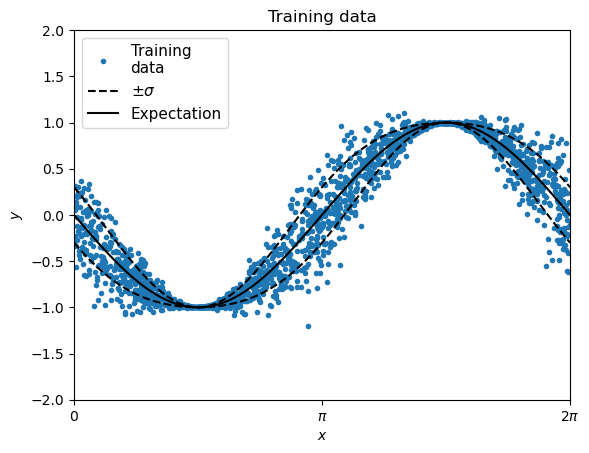

In [4]:
plt.plot(dataset.x[:2000], dataset.y[:2000], '.', label='Training \ndata')
plt.plot(dataset.x_uniform, dataset.confidence_lower, label='$\pm\sigma$', color='k', ls='--')
plt.plot(dataset.x_uniform, dataset.median, label='Expectation', color='k', ls='-')
plt.plot(dataset.x_uniform, dataset.confidence_upper, color='k', ls='--')
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, 0, np.pi], ['0', '$\pi$', '$2\pi$'])
plt.ylim([-2,2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left', fontsize=11)
plt.title('Training data')

In [137]:
# Define a fully connected neural network with one hidden layer
class FcNet(nn.Module):
    def __init__(self, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [138]:
mean_net = FcNet()
var_net = FcNet()

In [7]:
optimizer = optim.Adam(mean_net.parameters(), lr=1e-3)
num_epochs = 30
log = {'MSE': [], 'mean': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        MSE = ((mean-targets)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    mean = mean_net(dataset.x_uniform)
    log['MSE'].append(MSE_loss)
    log['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.4f}/{dataset.min_MSE:.4f}")

Epoch [1/30], Loss: 0.2182/0.0337
Epoch [2/30], Loss: 0.1094/0.0337
Epoch [3/30], Loss: 0.0639/0.0337
Epoch [4/30], Loss: 0.0519/0.0337
Epoch [5/30], Loss: 0.0460/0.0337
Epoch [6/30], Loss: 0.0410/0.0337
Epoch [7/30], Loss: 0.0374/0.0337
Epoch [8/30], Loss: 0.0355/0.0337
Epoch [9/30], Loss: 0.0346/0.0337
Epoch [10/30], Loss: 0.0343/0.0337
Epoch [11/30], Loss: 0.0342/0.0337
Epoch [12/30], Loss: 0.0341/0.0337
Epoch [13/30], Loss: 0.0340/0.0337
Epoch [14/30], Loss: 0.0340/0.0337
Epoch [15/30], Loss: 0.0339/0.0337
Epoch [16/30], Loss: 0.0339/0.0337
Epoch [17/30], Loss: 0.0339/0.0337
Epoch [18/30], Loss: 0.0339/0.0337
Epoch [19/30], Loss: 0.0339/0.0337
Epoch [20/30], Loss: 0.0338/0.0337
Epoch [21/30], Loss: 0.0338/0.0337
Epoch [22/30], Loss: 0.0338/0.0337
Epoch [23/30], Loss: 0.0338/0.0337
Epoch [24/30], Loss: 0.0338/0.0337
Epoch [25/30], Loss: 0.0338/0.0337
Epoch [26/30], Loss: 0.0338/0.0337
Epoch [27/30], Loss: 0.0338/0.0337
Epoch [28/30], Loss: 0.0338/0.0337
Epoch [29/30], Loss: 0.0338/0

In [8]:
optimizer = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 30
log_var = {'MSE': [], 'var': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        r2 = (targets-mean)**2
        var = (var_net(inputs))**2 # squared to predict positive variance
        MSE = ((var-r2)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    var = (var_net(dataset.x_uniform))**2
    log_var['MSE'].append(MSE_loss)
    log_var['var'].append(var.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.4f}")

Epoch [1/30], Loss: 0.0054
Epoch [2/30], Loss: 0.0046
Epoch [3/30], Loss: 0.0045
Epoch [4/30], Loss: 0.0045
Epoch [5/30], Loss: 0.0045
Epoch [6/30], Loss: 0.0045
Epoch [7/30], Loss: 0.0045
Epoch [8/30], Loss: 0.0045
Epoch [9/30], Loss: 0.0045
Epoch [10/30], Loss: 0.0045
Epoch [11/30], Loss: 0.0045
Epoch [12/30], Loss: 0.0045
Epoch [13/30], Loss: 0.0045
Epoch [14/30], Loss: 0.0045
Epoch [15/30], Loss: 0.0045
Epoch [16/30], Loss: 0.0045
Epoch [17/30], Loss: 0.0045
Epoch [18/30], Loss: 0.0045
Epoch [19/30], Loss: 0.0045
Epoch [20/30], Loss: 0.0045
Epoch [21/30], Loss: 0.0045
Epoch [22/30], Loss: 0.0045
Epoch [23/30], Loss: 0.0045
Epoch [24/30], Loss: 0.0045
Epoch [25/30], Loss: 0.0045
Epoch [26/30], Loss: 0.0045
Epoch [27/30], Loss: 0.0045
Epoch [28/30], Loss: 0.0045
Epoch [29/30], Loss: 0.0045
Epoch [30/30], Loss: 0.0045


In [ ]:
plt.plot(dataset.x[:5000],dataset.y[:5000],'.')
mean = log['mean'][-1]
std = np.sqrt(log_var['var'][-1])
plt.plot(dataset.x_uniform,mean.detach(),'-', lw=5)
plt.plot(dataset.x_uniform,mean.detach()+std,'-', lw=5)
plt.plot(dataset.x_uniform,mean.detach()-std,'-', lw=5)
plt.plot(dataset.x_uniform,dataset.median, color='k')
plt.plot(dataset.x_uniform,dataset.confidence_lower, color='k')
plt.plot(dataset.x_uniform,dataset.confidence_upper, color='k')

In [143]:
def plot_epoch(epoch=10):
    plt.figure(figsize=(4,4))
    plt.plot(dataset.x[:2000],dataset.y[:2000],'.', label='training \ndata')
    if epoch < 30:
        mean = log['mean'][epoch]
        std = 0 * mean
    else:
        mean = log['mean'][-1]
        std = np.sqrt(log_var['var'][epoch-30])
    plt.plot(dataset.x_uniform,mean,'-', lw=1, color='k', label='Expectation')
    plt.plot(dataset.x_uniform,mean-std,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(dataset.x_uniform,mean+std,'--', lw=1, color='k')
    plt.xlim([-np.pi, np.pi])
    plt.xticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
    plt.ylim([-2.2,2.2])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN')

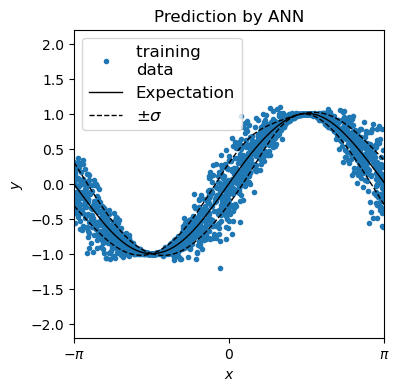

In [11]:
plot_epoch(59)
plt.show()

In [12]:
create_animation(plot_epoch, idx=np.arange(0,60,1), filename='SimpleUQ.gif', FPS=10)

Animation at FPS=10 will last for 6.0 seconds


# Test on WHOI data set

In [90]:
import xarray as xr
base = '/Users/jwu/Work/Dabble/MLFLUXES-main/data/'
ds = xr.open_dataset(base+'WHOI/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc')

In [89]:
ds

<xarray.Dataset>
Dimensions:                           (trajectory: 1, obs: 5040)
Coordinates:
  * trajectory                        (trajectory) int32 -2147483647
    time                              (obs, trajectory) datetime64[ns] ...
    lat                               (obs, trajectory) float64 ...
    lon                               (obs, trajectory) float64 ...
    zu                                (obs, trajectory) float64 ...
    ztq                               (obs, trajectory) float64 ...
    zsea                              (obs, trajectory) float64 ...
    zu_ship                           (obs, trajectory) float64 ...
    ztq_ship                          (obs, trajectory) float64 ...
    zsea_ship                         (obs, trajectory) float64 ...
Dimensions without coordinates: obs
Data variables: (12/97)
    RonBrown                          (trajectory) |S1 b''
    crs                               float64 ...
    rain_instrument                   (trajectory) |S1 b''
    shortwave_radiation_instrument_1  (trajectory) |S1 b''
    shortwave_radiation_instrument_2  (trajectory) |S1 b''
    longwave_radiation_instrument_1   (trajectory) |S1 b''
    ...                                ...
    ch                                (obs, trajectory) float64 0.001056 ... ...
    evap                              (obs, trajectory) float64 0.2561 ... 0....
    rough_u                           (obs, trajectory) float64 4.7e-05 ... 5...
    rough_t                           (obs, trajectory) float64 6.117e-05 ......
    rough_q                           (obs, trajectory) float64 6.117e-05 ......
    gust                              (obs, trajectory) float64 0.7564 ... 0....
Attributes: (12/33)
    title:                     ATOMIC (Atlantic Tradewind Ocean Atmosphere Me...
    summary:                   The data come from two sources, the NOAA PSL s...
    keywords:                  Earth Science > Atmosphere > Atmospheric Press...
    keywords_vocabulary:       GCMD Earth Science Keywords. Version 8.6
    comment:                   The PSL data (variables without suffix) should...
    instrument:                In Situ Instruments from NOAA PSL and the perm...
    ...                        ...
    cdm_data_type:             Trajectory
    date_created:              2021-03-30T16:13:03Z
    date_modified:             2021-03-30T16:13:03Z
    standard_name_vocabulary:  CF Standard Name Table v41
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3

Text(0, 0.5, 'Bulk formula $\\tau$')

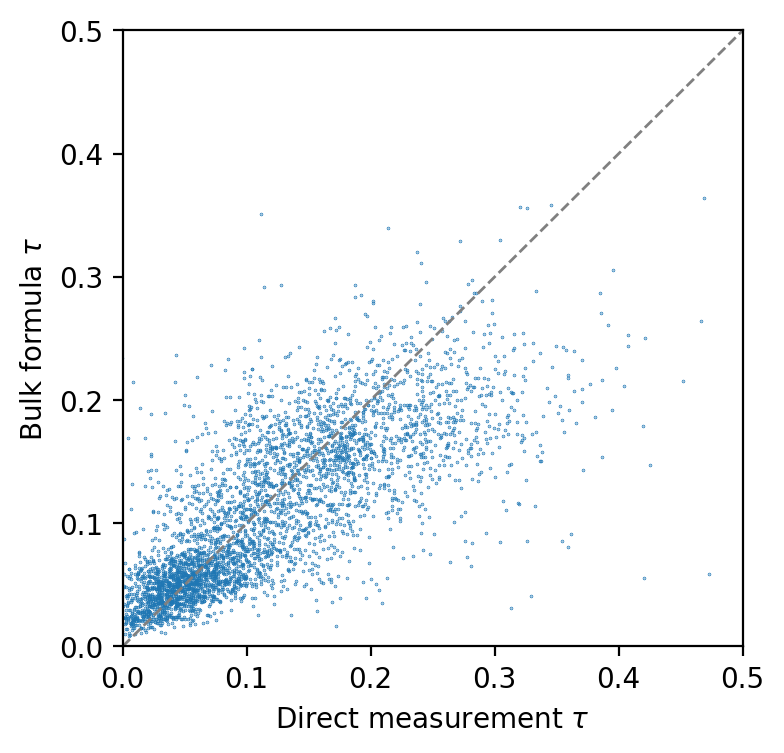

In [18]:
from matplotlib import pyplot as plt
import numpy as np
figure = plt.figure(figsize=[4,4], dpi=200)
plt.plot(ds.tau_streamwise_cov, ds.tau_bulk, '.', markersize=0.5)
plt.plot(np.linspace(0,0.5,100), np.linspace(0,0.5,100), '--', color='gray',lw=1)
plt.xlim([0,0.5]); plt.ylim([0,0.5])
plt.xlabel(r'Direct measurement $\tau$'); plt.ylabel(r'Bulk formula $\tau$')

Text(0, 0.5, '$\\tau_{\\text{cross}}/\\tau_\\text{along}$')

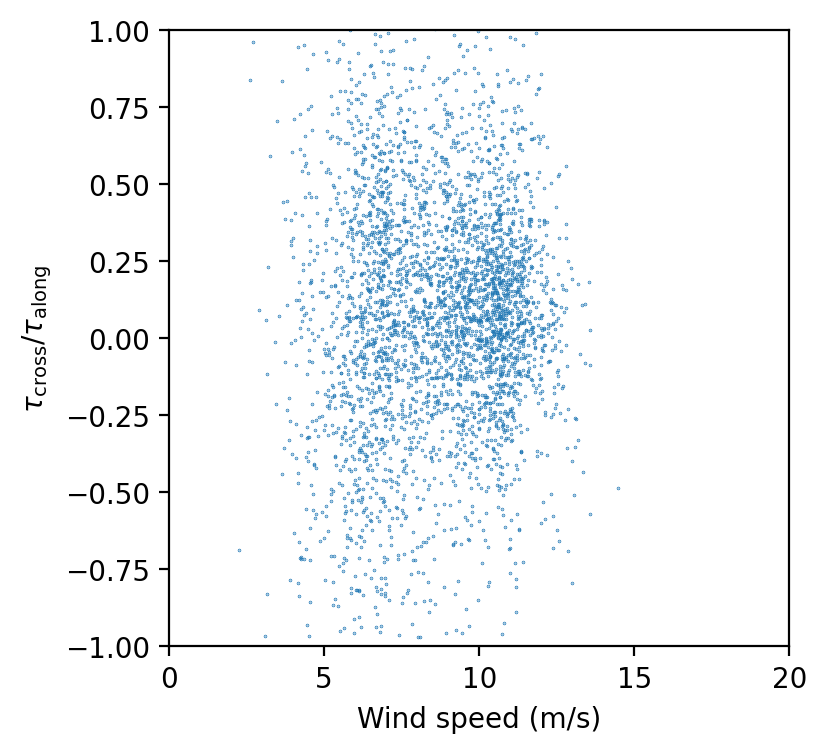

In [26]:
from matplotlib import pyplot as plt
import numpy as np
figure = plt.figure(figsize=[4,4], dpi=200)
plt.plot(ds.wspd, ds.tau_crossstream_cov/ds.tau_streamwise_cov, '.', markersize=0.5)
# plt.plot(np.linspace(0,0.5,100), np.linspace(0,0.5,100), '--', color='gray',lw=1)
plt.xlim([0,20]); plt.ylim([-1,1])
plt.xlabel(r'Wind speed (m/s)'); plt.ylabel(r'$\tau_{\text{cross}}/\tau_\text{along}$')

In [221]:
class FluxDataset(Dataset):
    def __init__(self, ds, namelist={'U':'wspd', 'tau':'tau_streamwise_cov'}):
        ''' TODO: write naming the fields using namelist '''
        self.x = torch.tensor(ds.wspd.values.astype('float32'))
        self.y = torch.tensor(ds.tau_streamwise_cov.values.astype('float32'))
        self.x_uniform = torch.tensor(np.linspace(0,15,100).astype('float32')).view(100,1)
        self.tau_bulk = torch.tensor(ds.tau_bulk.values.astype('float32'))
        self.min_MSE = ((self.tau_bulk-self.y)**2).mean() # WHY IS THIS NOT WORKING??
        # self.min_MSE = torch.mean((self.tau_bulk-self.y)**2)
        # self.U = torch.tensor(ds.wspd.values)
        # self.taux = torch.tensor(ds.tau_streamwise_cov.values)
        # self.tauy = torch.tensor(ds.crossstream_cov.values)
        
    def __len__(self):
        return len(self.x)

    # This function gives what DataLoader iterates over
    def __getitem__(self, idx):
        #return torch.cat(self.x1[idx], self.x2[idx], dim=1), self.y[idx]
        return self.x[idx], self.y[idx]    

In [222]:
ds_clean = ds.dropna(dim="obs", how="any", subset=["tau_streamwise_cov","tau_bulk","wspd"])
dataset = FluxDataset(ds=ds_clean)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

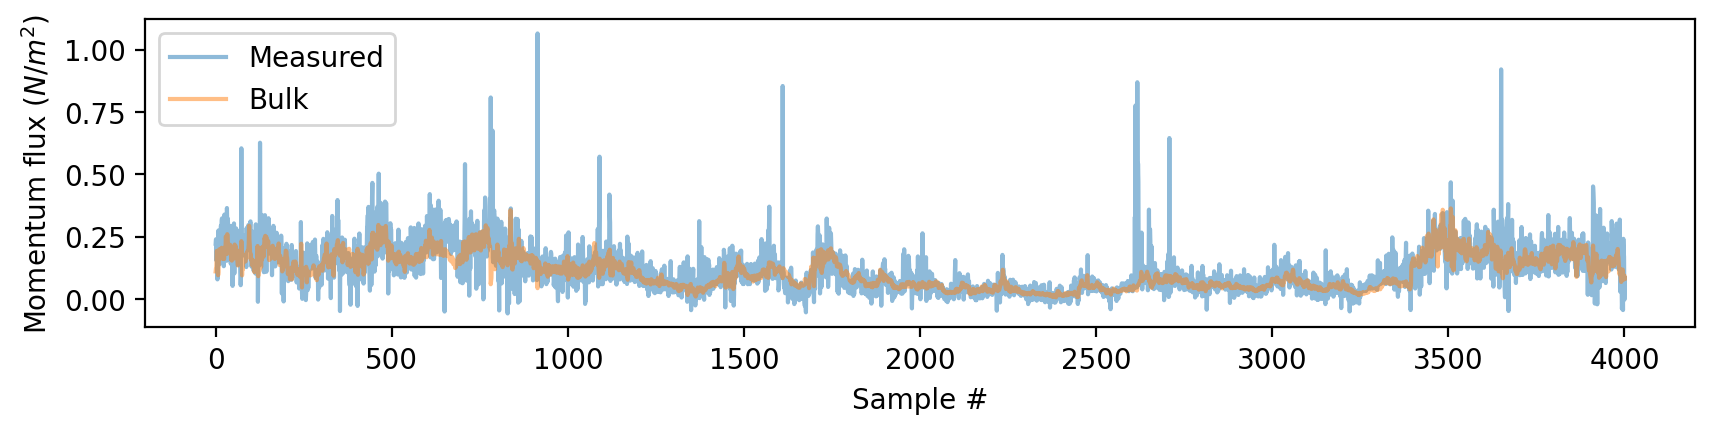

In [171]:
fig = plt.figure(figsize=[10,2], dpi=200)
plt.plot(ds_clean.tau_streamwise_cov, alpha=0.5, label='Measured')
plt.plot(ds_clean.tau_bulk, alpha=0.5, label='Bulk')
plt.xlabel('Sample #')
plt.ylabel(r'Momentum flux ($N/m^2$)')
plt.legend()
# plt.plot(ds_clean.wspd/10)

In [270]:
# Define a fully connected neural network with one hidden layer
class FcNet(nn.Module):
    def __init__(self, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [271]:
mean_net = FcNet(hidden_dim=32)
var_net = FcNet(hidden_dim=32)

In [272]:
optimizer = optim.Adam(mean_net.parameters(), lr=1e-3)
num_epochs = 30
log = {'MSE': [], 'mean': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        MSE = ((mean-targets)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    mean = mean_net(dataset.x_uniform)
    log['MSE'].append(MSE_loss)
    log['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.6f}/{dataset.min_MSE:.6f}")

Epoch [1/30], Loss: 0.021175/0.004587
Epoch [2/30], Loss: 0.006989/0.004587
Epoch [3/30], Loss: 0.006393/0.004587
Epoch [4/30], Loss: 0.006364/0.004587
Epoch [5/30], Loss: 0.006416/0.004587
Epoch [6/30], Loss: 0.006454/0.004587
Epoch [7/30], Loss: 0.006000/0.004587
Epoch [8/30], Loss: 0.006159/0.004587
Epoch [9/30], Loss: 0.006204/0.004587
Epoch [10/30], Loss: 0.006052/0.004587
Epoch [11/30], Loss: 0.006015/0.004587
Epoch [12/30], Loss: 0.005808/0.004587
Epoch [13/30], Loss: 0.005802/0.004587
Epoch [14/30], Loss: 0.005736/0.004587
Epoch [15/30], Loss: 0.005579/0.004587
Epoch [16/30], Loss: 0.005502/0.004587
Epoch [17/30], Loss: 0.005413/0.004587
Epoch [18/30], Loss: 0.005374/0.004587
Epoch [19/30], Loss: 0.005248/0.004587
Epoch [20/30], Loss: 0.005054/0.004587
Epoch [21/30], Loss: 0.005012/0.004587
Epoch [22/30], Loss: 0.004996/0.004587
Epoch [23/30], Loss: 0.004799/0.004587
Epoch [24/30], Loss: 0.004759/0.004587
Epoch [25/30], Loss: 0.004716/0.004587
Epoch [26/30], Loss: 0.004650/0.00

In [ ]:
''' Variance network trained on MSE '''
optimizer = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 30
log_var = {'MSE': [], 'var': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        r2 = (targets-mean)**2
        var = (var_net(inputs))**2 # squared to predict positive variance
        MSE = ((var-r2)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    var = (var_net(dataset.x_uniform))**2
    log_var['MSE'].append(MSE_loss)
    log_var['var'].append(var.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.8f}")

In [266]:
''' Variance network trained on log likelihood '''

optimizer_joint = optim.Adam(list(var_net.parameters())+list(mean_net.parameters()), lr=1e-3)
# optimizer_joint = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 30
log_var = {'LLLoss': [], 'var': [], 'mean': []}

loss = nn.GaussianNLLLoss()

for epoch in range(num_epochs):
    LLLoss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer_joint.zero_grad()
        # Forward pass
        mean = mean_net(inputs)
        var = (var_net(inputs))**2 # squared to predict positive variance
        likelihood = loss(targets, mean, var).mean()   
        # Backward and optimize (var and mean net)
        likelihood.backward() # TODO: Only need to call this once right?
        optimizer_joint.step()
        LLLoss += likelihood.item() * len(inputs)        

    LLLoss = LLLoss / len(dataset)
    var = (var_net(dataset.x_uniform))**2
    mean = mean_net(dataset.x_uniform)
    log_var['LLLoss'].append(LLLoss)
    log_var['var'].append(var.detach())
    log_var['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {LLLoss:.8f}")

Epoch [1/30], Loss: -0.73793760
Epoch [2/30], Loss: -2.01554501
Epoch [3/30], Loss: -2.01408346
Epoch [4/30], Loss: -2.00847440
Epoch [5/30], Loss: -1.71924590
Epoch [6/30], Loss: -1.86213052
Epoch [7/30], Loss: -1.64437203
Epoch [8/30], Loss: -2.00066952
Epoch [9/30], Loss: -1.83660988
Epoch [10/30], Loss: -1.65103275
Epoch [11/30], Loss: -1.92437421
Epoch [12/30], Loss: -1.91050503
Epoch [13/30], Loss: -1.85387717
Epoch [14/30], Loss: -1.19379999
Epoch [15/30], Loss: -1.28332349
Epoch [16/30], Loss: -1.91532306
Epoch [17/30], Loss: -2.00927679
Epoch [18/30], Loss: -1.85845267
Epoch [19/30], Loss: -1.84818890
Epoch [20/30], Loss: -1.90758491
Epoch [21/30], Loss: -1.98914359
Epoch [22/30], Loss: -1.89174221
Epoch [23/30], Loss: -1.88823471
Epoch [24/30], Loss: -1.90143137
Epoch [25/30], Loss: -2.01369407
Epoch [26/30], Loss: -1.51715461
Epoch [27/30], Loss: -1.62362220
Epoch [28/30], Loss: -1.97517971
Epoch [29/30], Loss: -2.08381687
Epoch [30/30], Loss: -1.54398519


In [167]:
def plot_epoch(epoch=10):
    plt.figure(figsize=(5,5))
    plt.plot(dataset.x[:2000],dataset.y[:2000],'.', markersize=0.5, label='training \ndata')
    if epoch < 30:
        mean = log['mean'][epoch]
        std = 0 * mean
    else:
        mean = log['mean'][-1]
        std = np.sqrt(log_var['var'][epoch-30])
    plt.plot(dataset.x_uniform,mean,'-', lw=1, color='k', label='Expectation')
    plt.plot(dataset.x_uniform,mean-std,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(dataset.x_uniform,mean+std,'--', lw=1, color='k')
    plt.xlim([0,15])
    # plt.xticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
    plt.ylim([0,0.5])
    plt.xlabel('Wind speed $(m/s)$')
    plt.ylabel('Momentum flux $(N/m^2)$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN')

In [236]:
def plot_epoch_new(epoch=10):
    plt.figure(figsize=(5,5))
    plt.plot(dataset.x[:2000],dataset.y[:2000],'.', markersize=0.5, label='training \ndata')
    if epoch < 30:
        mean = log['mean'][epoch]
        std = 0 * mean
    else:
        mean = log_var['mean'][epoch-30]
        # mean = log['mean'][-1]
        std = np.sqrt(log_var['var'][epoch-30])
    plt.plot(dataset.x_uniform,mean,'-', lw=1, color='k', label='Expectation')
    plt.plot(dataset.x_uniform,mean-std,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(dataset.x_uniform,mean+std,'--', lw=1, color='k')
    plt.xlim([0,15])
    # plt.xticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
    plt.ylim([0,0.5])
    plt.xlabel('Wind speed $(m/s)$')
    plt.ylabel('Momentum flux $(N/m^2)$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN')

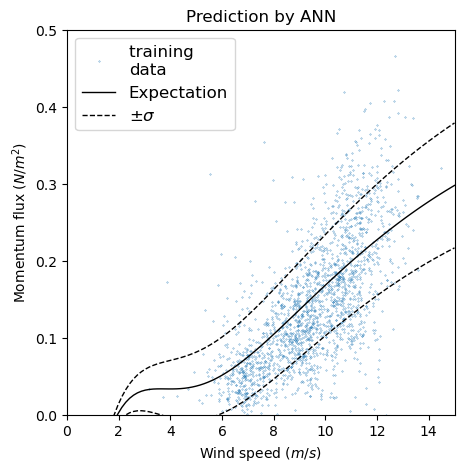

In [267]:
plot_epoch_new(58)
plt.show()

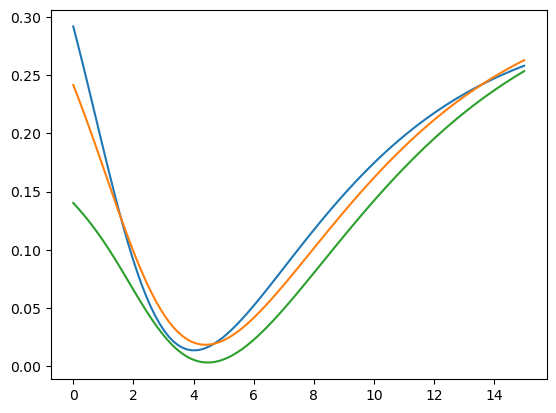

In [255]:
plt.plot(dataset.x_uniform, log['mean'][0])
plt.plot(dataset.x_uniform, log['mean'][1])
plt.plot(dataset.x_uniform, log['mean'][2])
# plt.plot(dataset.x_uniform, log_var['mean'][0])
# plt.plot(dataset.x_uniform, log_var['mean'][1])
# plt.plot(dataset.x_uniform, log_var['var'][0])
# plt.plot(dataset.x_uniform, log_var['var'][1])
# plt.plot(dataset.x_uniform, log_var['var'][2])
# plt.plot(dataset.x_uniform, log_var['var'][3])
# plt.plot(log_var['mean'][1])

In [268]:
create_animation(plot_epoch_new, idx=np.arange(0,60,1), filename='FluxUQ.gif', FPS=10)

Animation at FPS=10 will last for 6.0 seconds
